# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [0]:
import time
import numpy as np
from torch.autograd import Variable
from itertools import chain
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import math
import matplotlib.pyplot as plt
%matplotlib inline

**Collab setting**

In [135]:
!nvidia-smi

Mon Apr 20 16:13:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    61W / 149W |   1930MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [136]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring20/homework03/lfw_dataset.py -O lfw_dataset.py

--2020-04-20 16:13:34--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring20/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2819 (2.8K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-04-20 16:13:34 (33.5 MB/s) - ‘lfw_dataset.py’ saved [2819/2819]



In [0]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset(dimx=36,dimy=36)


In [0]:
data = data/255
np.savez("real.npz", Pictures=data.reshape(data.shape[0], 36*36*3))

In [139]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 3888)
(3143, 3888)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [0]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

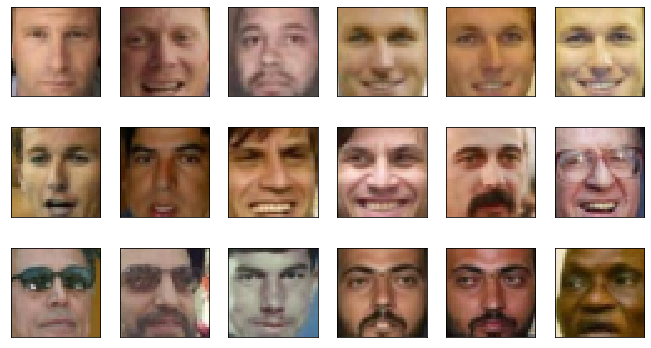

In [142]:
plot_gallery(X_train, image_h, image_w)

In [0]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [0]:
dimX = 3888
dimH = 1024
dimZ = 256 # Considering face reconstruction task, which size of representation seems reasonable?


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(dimX, dimH),
            nn.BatchNorm1d(dimH),
            nn.ReLU(),
            nn.Linear(dimH, dimH),
            nn.BatchNorm1d(dimH),
            nn.ReLU(),
            nn.Linear(dimH, dimZ)        
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, dimH),
            nn.BatchNorm1d(dimH),
            nn.ReLU(),
            nn.Linear(dimH, dimH),
            nn.BatchNorm1d(dimH),
            nn.ReLU(),
            nn.Linear(dimH, dimX),
            nn.Sigmoid()
        )

        for module in chain(self.encoder.modules(), self.decoder.modules()):
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
            if isinstance(module, nn.BatchNorm1d):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

        
    def forward(self, x):
              
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [0]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

In [146]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
N_EPOCHS = 100
VAL_INTERVAL = 5

train_losses = []
image_progress = []

for epoch in range(N_EPOCHS):
    print('Epoch {} started...'.format(epoch + 1))
    epoch_losses = []
    start_time = time.time()

    autoencoder.train()
    for X_batch, _ in train_loader:
        reconstruction, _ = autoencoder(X_batch.cuda())

        loss = criterion(X_batch.cuda(), reconstruction)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        epoch_losses.append(loss.item())

    train_loss = np.mean(epoch_losses)
    train_losses.append(train_loss)

    print('Train MSE Loss: {}'.format(train_loss))
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, N_EPOCHS, time.time() - start_time))  

    if epoch % 5 == 0:
        for i, (putin, y) in enumerate(val_loader):
            if i == 2754:
                break
        
        autoencoder.eval()
        pred, _ = autoencoder(Variable(putin.cuda()))
        image_progress.append(pred)

Epoch 1 started...
Train MSE Loss: 0.012348972577601671
Epoch 1 of 100 took 1.781s
Epoch 2 started...
Train MSE Loss: 0.00837822419591248
Epoch 2 of 100 took 1.665s
Epoch 3 started...
Train MSE Loss: 0.007346773385070265
Epoch 3 of 100 took 1.676s
Epoch 4 started...
Train MSE Loss: 0.006693997266702354
Epoch 4 of 100 took 1.690s
Epoch 5 started...
Train MSE Loss: 0.006144965896382928
Epoch 5 of 100 took 1.683s
Epoch 6 started...
Train MSE Loss: 0.005839382181875408
Epoch 6 of 100 took 1.679s
Epoch 7 started...
Train MSE Loss: 0.005531010697595775
Epoch 7 of 100 took 1.662s
Epoch 8 started...
Train MSE Loss: 0.0053236449928954245
Epoch 8 of 100 took 1.667s
Epoch 9 started...
Train MSE Loss: 0.005137312565930188
Epoch 9 of 100 took 1.677s
Epoch 10 started...
Train MSE Loss: 0.004848716096021235
Epoch 10 of 100 took 1.658s
Epoch 11 started...
Train MSE Loss: 0.0047559843631461264
Epoch 11 of 100 took 1.660s
Epoch 12 started...
Train MSE Loss: 0.004647255036979913
Epoch 12 of 100 took 1.66

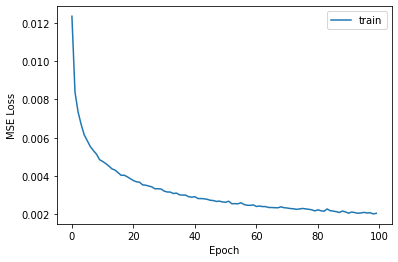

In [147]:
plt.plot(train_losses, label="train")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.show()

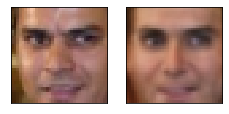

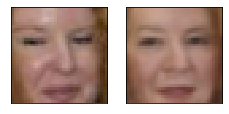

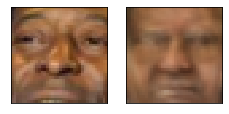

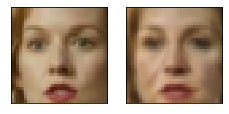

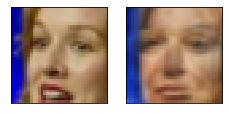

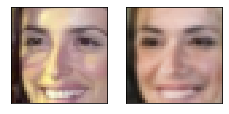

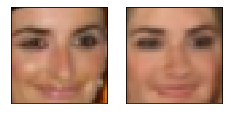

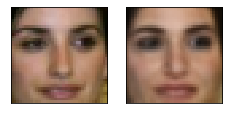

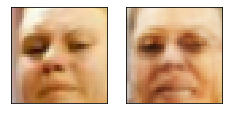

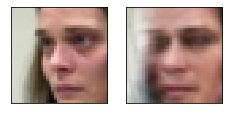

In [148]:
# Examine the reconstructions

autoencoder.eval()
for j, data in enumerate(val_loader, 0):
    inp = Variable(data[0].cuda())
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

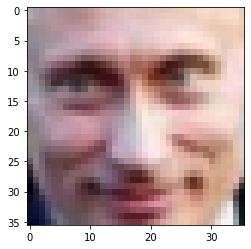

In [149]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
plt.imshow(putin.numpy().reshape((image_w, image_w, 3)))

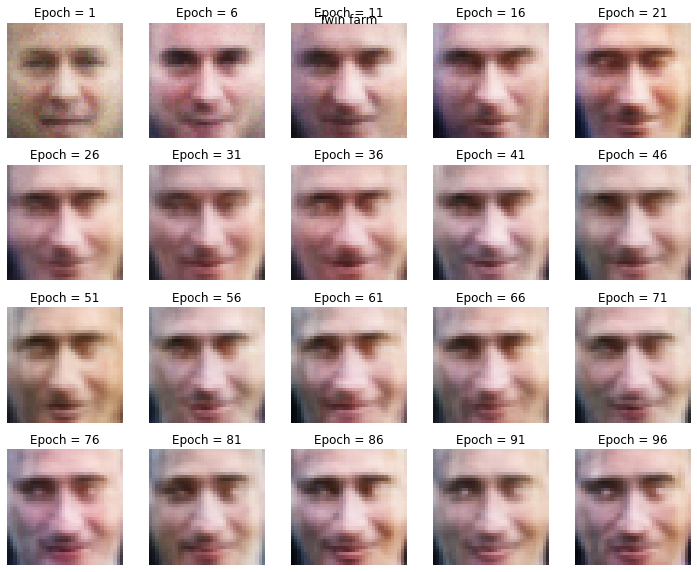

In [150]:
plt.figure(figsize=(10, 12))
plt.suptitle('Twin farm')
for i in range(len(image_progress[:20])):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(6, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3))
    plt.title('Epoch = {}'.format(i * 5 + 1))
    plt.axis('off')
plt.tight_layout()

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

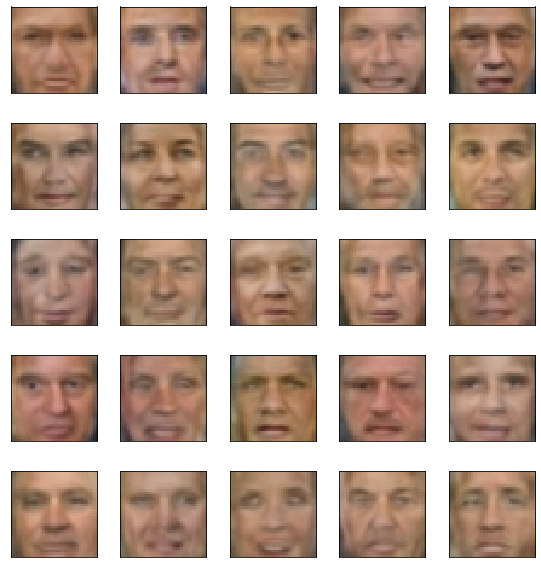

In [151]:
z = (np.random.randn(25, dimZ) * 4).astype('float32')
output = autoencoder.decoder(Variable(torch.from_numpy(z)).cuda()).clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

Q: So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

A: No, becuase there is no guarantee that z latent vectors obtained from the train sample are normally distributed


# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [0]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimX = 3888
dimH = 1024
dimZ = 256


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(dimX, dimH),
            nn.BatchNorm1d(dimH)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(dimH, dimH),
            nn.BatchNorm1d(dimH),
        )

        self.encoder_to_mu = nn.Linear(dimH, dimZ)
        self.encoder_to_logsigma = nn.Linear(dimH, dimZ)

        self.layer3 = nn.Sequential(
            nn.Linear(dimZ, dimH),
            nn.BatchNorm1d(dimH),
        )

        self.layer4 = nn.Sequential(
            nn.Linear(dimH, dimH),
            nn.BatchNorm1d(dimH)
        )

        self.decoder_to_mu = nn.Linear(dimH, dimX)
        self.decoder_to_logsigma = nn.Linear(dimH, dimX)

    def encode(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        mu = self.encoder_to_mu(x)
        logsigma = self.encoder_to_logsigma(x)
        return mu, logsigma 

    def decode(self, z):
        z = F.relu(self.layer3(z))
        z = F.relu(self.layer4(z))
        mu = self.decoder_to_mu(z)
        logsigma = self.decoder_to_logsigma(z)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add(mu)
        else:
            return mu

    def forward(self, x):
        latent_mu, latent_logsigma = self.encode(x)
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(z)

        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [0]:
def KL_divergence(mu, logsigma):
    div = torch.mean(-0.5 * torch.sum(1 + 2 * logsigma - logsigma.exp() ** 2 - mu ** 2, dim=1))
    return div

def log_likelihood(x, mu, logsigma):
    term1 = 1 / (logsigma.exp() * math.sqrt(2 * math.pi)) 
    term2 = -1 * (mu - x).pow(2) / (2 * logsigma.exp().pow(2))
    ll = torch.mean(torch.sum(torch.log(term1) + term2, dim=1))
    return ll

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    KLD = KL_divergence(mu_z, logsigma_z)
    LL = log_likelihood(x, mu_gen, logsigma_gen)
    return KLD - LL

And train the model:

In [154]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

vae = VAE().cuda()
optimizer = optim.Adam(vae.parameters(), 1e-3)

N_EPOCHS = 200
VAL_INTERVAL = 10

train_losses = []
image_progress = []

for epoch in range(N_EPOCHS):
    print('Epoch {} started...'.format(epoch + 1))
    epoch_losses = []
    start_time = time.time()

    vae.train()
    for X_batch, _ in train_loader:
        reconstruction_mu, reconstruction_logsigma, \
                latent_mu, latent_logsigma = vae(X_batch.cuda())

        loss = loss_vae(X_batch.cuda(), reconstruction_mu, 
                        reconstruction_logsigma, latent_mu, latent_logsigma)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        epoch_losses.append(loss.item())

    train_loss = np.mean(epoch_losses)
    train_losses.append(train_loss)

    print('Train MSE Loss: {}'.format(train_loss))
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, N_EPOCHS, time.time() - start_time))  

    if epoch % 5 == 0:
        for i, (putin, y) in enumerate(val_loader):
            if i == 2754:
                break
        
        vae.eval()
        pred, _, _, _= vae(Variable(putin.cuda()))
        image_progress.append(pred)

Epoch 1 started...
Train MSE Loss: 177.41681625366212
Epoch 1 of 200 took 2.485s
Epoch 2 started...
Train MSE Loss: -1684.9349699401855
Epoch 2 of 200 took 2.389s
Epoch 3 started...
Train MSE Loss: -1391.1548937988282
Epoch 3 of 200 took 2.360s
Epoch 4 started...
Train MSE Loss: -2095.1508197021485
Epoch 4 of 200 took 2.407s
Epoch 5 started...
Train MSE Loss: -2583.8275146484375
Epoch 5 of 200 took 2.395s
Epoch 6 started...
Train MSE Loss: -2596.374153442383
Epoch 6 of 200 took 2.376s
Epoch 7 started...
Train MSE Loss: -2886.7147827148438
Epoch 7 of 200 took 2.373s
Epoch 8 started...
Train MSE Loss: -3027.608659667969
Epoch 8 of 200 took 2.381s
Epoch 9 started...
Train MSE Loss: -3065.142734375
Epoch 9 of 200 took 2.375s
Epoch 10 started...
Train MSE Loss: -3215.245458984375
Epoch 10 of 200 took 2.370s
Epoch 11 started...
Train MSE Loss: -3337.958359375
Epoch 11 of 200 took 2.359s
Epoch 12 started...
Train MSE Loss: -3229.9243701171877
Epoch 12 of 200 took 2.368s
Epoch 13 started...
Tr

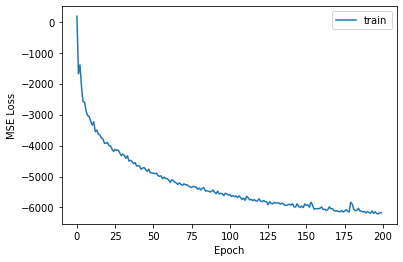

In [155]:
plt.plot(train_losses, label="train")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


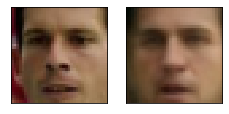

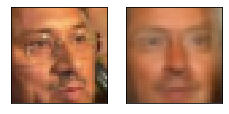

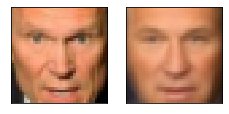

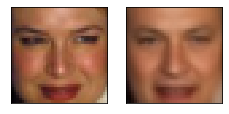

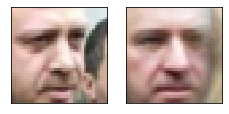

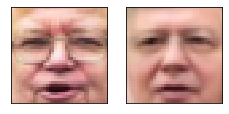

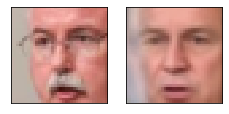

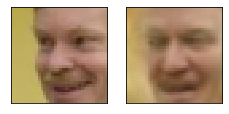

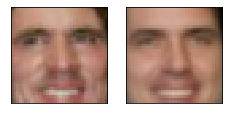

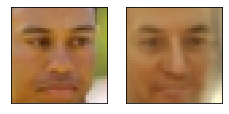

In [156]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = Variable(data[0].cuda())
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

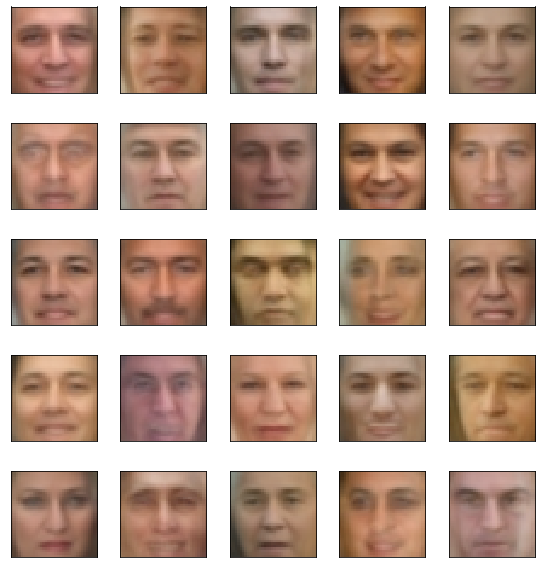

In [157]:
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
vae.eval()

z = (np.random.randn(25, dimZ)).astype('float32')
decoder_mu, decoder_sigma = vae.decode(Variable(torch.from_numpy(z)).cuda())

decoder_mu = decoder_mu.data.cpu().numpy().clip(0, 1)
decoder_sigma = decoder_sigma.data.cpu().numpy().clip(0, 1)

output = (decoder_sigma * np.random.randn(25, dimX) + decoder_mu).astype('float32')
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

## If you are going to do part 4 (presicion-recall score): 

In [0]:
data, attrs = fetch_lfw_dataset(dimx=36,dimy=36)
data = data / 255

In [0]:
# using your model, generate face set with len = len(data)
vae.eval()

z = (np.random.randn(data.shape[0], dimZ)).astype('float32')
decoder_mu, decoder_sigma = vae.decode(Variable(torch.from_numpy(z)).cuda())

decoder_mu = decoder_mu.data.cpu().numpy().clip(0, 1)
decoder_sigma = decoder_sigma.data.cpu().numpy().clip(0, 1)

answ = (decoder_sigma * np.random.randn(data.shape[0], dimX) + decoder_mu).astype('float32')

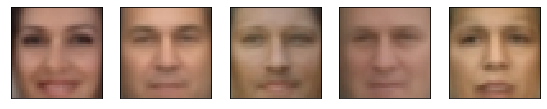

In [160]:
plot_gallery(answ, image_h, image_w, n_row=1, n_col=5)

## Save it ot npz

In [0]:
np.savez("vae.npz", Pictures=answ)

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

In [0]:
NO_SMILE = -2.5
SMILE = 2.5

In [0]:
smiles = attrs[attrs['Smiling'] > SMILE]
no_smiles = attrs[attrs['Smiling'] < NO_SMILE]

In [0]:
smiling_faces = np.array([data[idx].flatten().astype('float32') for idx in smiles.index])
not_smiling_faces = np.array([data[idx].flatten().astype('float32') for idx in no_smiles.index])

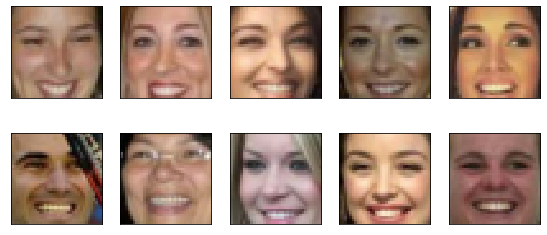

In [249]:
plot_gallery(smiling_faces, image_h, image_w, n_row=2, n_col=5)

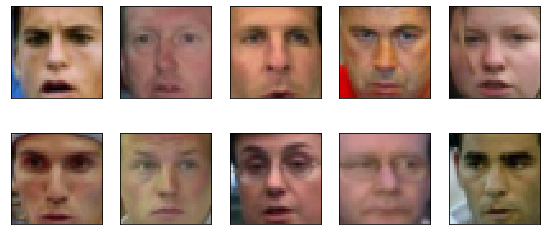

In [250]:
plot_gallery(not_smiling_faces, image_h, image_w, n_row=2, n_col=5)

## Autoencoder

In [0]:
z = autoencoder.encoder(torch.from_numpy(smiling_faces).cuda())
smile_latent_vector = torch.mean(z, dim=0)

In [0]:
z = autoencoder.encoder(torch.from_numpy(not_smiling_faces).cuda())
no_smile_latent_vector = torch.mean(z, dim=0)

In [0]:
diff = smile_latent_vector - no_smile_latent_vector

In [0]:
not_smiling = autoencoder.encoder(torch.from_numpy(not_smiling_faces).cuda())

moved_vector = not_smiling + diff

smiling = autoencoder.decoder(moved_vector)

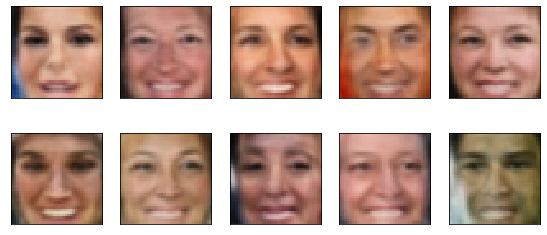

In [255]:
plot_gallery(smiling.data.cpu(), image_h, image_w, n_row=2, n_col=5)

## Variational AutoEncoder

In [0]:
mu, sigma = vae.encode(torch.from_numpy(smiling_faces).cuda())
smile_latent_vector = torch.mean(vae.gaussian_sampler(mu, sigma), dim=0)

In [0]:
mu, sigma = vae.encode(torch.from_numpy(not_smiling_faces).cuda())
no_smile_latent_vector = torch.mean(vae.gaussian_sampler(mu, sigma), dim=0)

In [0]:
diff = smile_latent_vector - no_smile_latent_vector

In [0]:
mu, sigma = vae.encode(torch.from_numpy(not_smiling_faces).cuda())
not_smiling = vae.gaussian_sampler(mu, sigma)

moved_vector = not_smiling + diff

mu, sigma = vae.decode(moved_vector)

mu = mu.data.cpu().numpy().clip(0, 1)
sigma = sigma.data.cpu().numpy().clip(0, 1)

smiling = (sigma * np.random.randn(not_smiling_faces.shape[0], dimX) + mu).astype('float32')

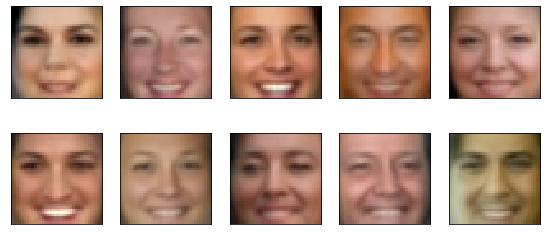

In [265]:
plot_gallery(smiling, image_h, image_w, n_row=2, n_col=5)